In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 97% 321M/330M [00:08<00:00, 40.6MB/s]
100% 330M/330M [00:08<00:00, 41.7MB/s]


**Dataset:**

In [5]:
from zipfile import ZipFile
zip = ZipFile('face-mask-12k-images-dataset.zip')
zip.extractall()

**Imports:**

In [6]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy


import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2


cudnn.benchmark=True
plt.ion()

In [7]:
from torchvision import datasets

In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)    

cuda


Either one:

**Transforms:**

In [86]:
data_transform={
    
    'Train':transforms.Compose([ #Augmentation + Resize + Normalization
        
        #Most of these transforms are applied to simulate low res images and to counter the skin colour bias for implementation in the indian demographic as dataset is primarily
        #white, washed out and saturated.

        transforms.RandomResizedCrop(224), #224 X 224 imgs
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3)), #Blur
        transforms.RandomAdjustSharpness(sharpness_factor=2), #Sharpening
        transforms.ColorJitter(brightness=(0.1,0.9), saturation=(0.5,0.9)),  #Changing Brightness and saturation 
        transforms.ToTensor(),                      #ImageNet's mean and SD values
        transforms.Normalize([0.485, 0.456, 0.406], #mean across each RGB channel
                             [0.229, 0.224, 0.225]) #SD across each RGB channel
                                                    #in range of (0,1)
    ]),
    
    'Validation': transforms.Compose([ #Resize + Normalization
        
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    
}            

**Albumentations:**

In [80]:
data_transform={
    
    'Train':A.Compose(
    [
        A.RandomCrop(height=224, width=224),
        A.Blur(blur_limit=3),
        A.GaussNoise(always_apply=False, p=1.0, mean=-65.42, var_limit=(20.1299991607666, 209.72999572753906)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
 ),
  


  'Validation':A.Compose(
    [
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
 )
}

In [53]:
Path="Face Mask Dataset"

**Split & DataLoader:**

In [87]:
dataset={x: datasets.ImageFolder(os.path.join(Path, x),data_transform[x]) #splitting into train and val based on folder in dataset
          for x in ['Train', 'Validation']
        }

dataloaders={x:torch.utils.data.DataLoader(dataset[x], batch_size=5,shuffle=True, num_workers=4) #defining dataloader for the model, number of dataset batches=5
              for x in ['Train', 'Validation']
            }

dataset_Size={x:len(dataset[x]) for x in ['Train','Validation']} #Determining size

label=dataset['Train'].classes #fetching labels

device=torch.device("cuda:0") #prereq for passing data onto the gpu


In [100]:
print(dataset_Size, label)

{'Train': 10000, 'Validation': 800} ['WithMask', 'WithoutMask']


**Viz func:**

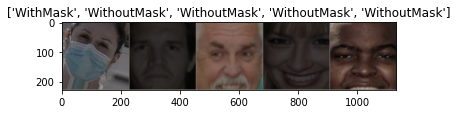

In [91]:
#BoilerPlate code for visualizing images with augs

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

**Training func:**

In [92]:
def training(model, criterion, optimizer, scheduler, epoch_count=20):
    
    start=time.time() #keep track of initial starting time for calculating elapsed time
    
    weight_of_BestModel=copy.deepcopy(model.state_dict()) #Initialize variables to save weights and accuracy of the best model that runs through the epoches
    
    acc_of_BestModel=0.0
    
    for epoch in range(epoch_count):
        
        print(f'Epoch Number: {epoch}/{epoch_count-1}') #displaying current epoch
        print('_'*20)
        
        for phase in['Train','Validation']: # 1 epoch = Training phase + Validation phase
            
            if phase=='Train':
                model.train()  #training phase
            else:
                model.eval() #eval phase
            
            running_loss=0.0
            running_corrects=0
            
            for inputs, labels in dataloaders[phase]:
                
                #passing dataset to GPU
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optimizer.zero_grad() #Zeroing gradients
                
                #enable gradients for forward pass
                
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs=model(inputs) #passing inputs to model
                    _, prediction=torch.max(outputs,1) #(max val of output, preds)
                    loss=criterion(outputs, labels) #cross entropy fn b/w predicted output and actual label-->loss function
                   
                #Optimize for backward pass of Train
                
                    if phase == "Train":
                        loss.backward() #calc gradients for backward pass
                        optimizer.step() #update parameters for each batch iteration
                        
                #Claculating loss
                
                running_loss=running_loss+ loss.item()*inputs.size(0)
                running_corrects=running_corrects+torch.sum(prediction==labels.data)
                
            if phase=="Train":
                scheduler.step() #change learning rate for each epoch-->lr deacy
             
            #Calc loss and acc for each epoch
            
            epoch_loss=running_loss/dataset_Size[phase]
            epoch_acc=running_corrects.double() / dataset_Size[phase]
            
            print(f'{phase} --> Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            #Updating acc_of_BestModel and copying weights into weight_of_BestModel if current epoch accuracy is higher  
         
            if phase=="Validation" and epoch_acc>acc_of_BestModel:
                acc_of_BestModel=epoch_acc
                weight_of_BestModel=copy.deepcopy(model.state_dict())
        
        print()
        
    #Calculating elapsed time:
    
    elapsed_time=time.time()-start
    
    print(f'Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')
    #printing highest acc
    print(f'Best val Acc: {acc_of_BestModel:4f}')
    
    #loading weight_of_BestModel
    
    model.load_state_dict(weight_of_BestModel)
    return model
    
    
    

**Pred Viz func:**

In [101]:
#boilerplate code for visualizing predicted images:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Either one:

**Reset FFC layer:**

Resnet:

In [94]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

**Fixed Feature Extraction:**

In [ ]:
pretrained_model=torchvision.models.resnet34(pretrained=True) #loading pretrained model-resnet34

for param in pretrained_model.parameters():
    
    param.requires_grad=False #freezing network params except for final layer where gradients are not calculated for backward pass

#Modifying the last fc layer

num_of_ftrs=pretrained_model.fc.in_features # calculating number of inputs for the layers

pretrained_model.fc=nn.Linear(num_of_ftrs, 2)

#passing to GPU
pretrained_model=pretrained_model.to(device)

#defining loss fn:

criterion=nn.CrossEntropyLoss()

optimizer_new=optim.SGD(pretrained_model.fc.parameters(), lr=0.001, momentum=0.9) #optimizer for last fc layer only --> SGD

#LR decay by 0.1 factor for every 7 epoches

exp_lr_scheduler= lr_scheduler.StepLR(optimizer_new, step_size=7, gamma=0.1)

    
    

**TRAIN:**

In [95]:
pretrained_model=training(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epoch_count=20)

Epoch Number: 0/19
____________________


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train --> Loss: 0.2419 Acc: 0.9103
Validation --> Loss: 0.2280 Acc: 0.9038

Epoch Number: 1/19
____________________
Train --> Loss: 0.0841 Acc: 0.9696
Validation --> Loss: 0.1484 Acc: 0.9387

Epoch Number: 2/19
____________________
Train --> Loss: 0.0546 Acc: 0.9808
Validation --> Loss: 0.1259 Acc: 0.9563

Epoch Number: 3/19
____________________
Train --> Loss: 0.0413 Acc: 0.9848
Validation --> Loss: 0.0045 Acc: 0.9988

Epoch Number: 4/19
____________________
Train --> Loss: 0.0378 Acc: 0.9861
Validation --> Loss: 0.2311 Acc: 0.9387

Epoch Number: 5/19
____________________
Train --> Loss: 0.0342 Acc: 0.9875
Validation --> Loss: 0.0166 Acc: 0.9950

Epoch Number: 6/19
____________________
Train --> Loss: 0.0364 Acc: 0.9877
Validation --> Loss: 0.0345 Acc: 0.9863

Epoch Number: 7/19
____________________
Train --> Loss: 0.0231 Acc: 0.9912
Validation --> Loss: 0.0241 Acc: 0.9888

Epoch Number: 8/19
____________________
Train --> Loss: 0.0192 Acc: 0.9930
Validation --> Loss: 0.0058 Acc: 0.99

**SAVE:**

In [96]:
torch.save(pretrained_model,'model.pth')
torch.save(pretrained_model.state_dict(),'model_weights.pth')

**Viz:**

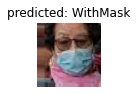

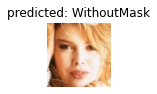

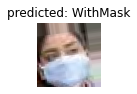

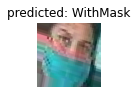

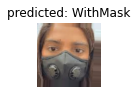

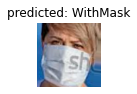

In [102]:
visualize_model(pretrained_model)
plt.ioff()
plt.show()